## Visualizing effect of prior on posterior using trace plots and rank plots'
We illustrate bad mixing MCMC chains using the example in sec 9.5  of [Statistical Rethinking ed 2](https://xcelab.net/rm/statistical-rethinking/)


author: @karm-patel


Please find numpyro implementation of this notebook here:https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book2/11/mcmc_traceplots_unigauss_numpyro.ipynb

In [1]:
import jax.numpy as jnp
import jax
import os

try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq blackjax
    import blackjax

try:
    import tensorflow_probability.substrates.jax as tfp
except:
    %pip install tensorflow_probability
    import tensorflow_probability.substrates.jax as tfp

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

In [2]:
# dataset
y = jnp.array([-1, 1])
n_chains = 3
n_samples = 1000
burn_in = 500

In [3]:
def inference_loop_multiple_chains(rng_key, kernel, initial_states, num_samples, num_chains):
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        # states and info is returned by blackjax model (kernel).
        # info contains additional info such as divergences, step_size, acceptance_probability, etc.
        states, info = jax.vmap(kernel)(keys, states)

        return states, {"states": states, "info": info}

    keys = jax.random.split(rng_key, num_samples)
    _, states_and_info = jax.lax.scan(one_step, initial_states, keys)

    return states_and_info

In [4]:
def create_trace_from_states(states, info, burn_in=0):
    """
    input: states & info which is returned by blackjax kernel
    output: make trace which can be directly passed to arviz
    """
    samples = {}
    for param in states.position.keys():
        ndims = len(states.position[param].shape)
        if ndims == 1:
            """
            states have only single chain
            """
            divergence = info.is_divergent[burn_in:]
            samples[param] = states.position[param][burn_in:]

        elif ndims > 1:
            """
            states have states.position[param].shape[1] chains
            blackjax states format: n_samples × n_chains × dims0 × dim1 × ..
            arviz.convert_to_inference_data() requires: n_chains × n_samples × dims0 × dim1 × ..
            """
            # so we swap n_samples and n_chains
            samples[param] = jnp.swapaxes(states.position[param][burn_in:], 0, 1)

            # get divergences
            divergence = jnp.swapaxes(info.is_divergent[burn_in:], 0, 1)

    trace_posterior = az.convert_to_inference_data(samples)
    trace_sample_stats = az.convert_to_inference_data({"diverging": divergence}, group="sample_stats")
    trace = az.concat(trace_posterior, trace_sample_stats)
    return trace, samples

## Diffuse prior

In [5]:
prior_alpha_bad = tfp.distributions.Normal(0, 1000)
prior_sigma_bad = tfp.distributions.Exponential(0.0001)

In [6]:
rng_key = jax.random.PRNGKey(2)
initial_positions = {
    "alpha": prior_alpha_bad.sample(n_chains, seed=rng_key),
    "sigma": prior_sigma_bad.sample(n_chains, seed=rng_key),
}
initial_positions

{'alpha': DeviceArray([ 428.515  , 1077.8004 ,  163.13783], dtype=float32),
 'sigma': DeviceArray([4066.731 , 1514.7595, 5712.9243], dtype=float32)}

In [7]:
def log_joint_prob_bad_prior(params, obs_data=y):
    alpha, sigma = params["alpha"], params["sigma"]
    # prior
    log_prob_alpha = prior_alpha_bad.log_prob(alpha)
    log_prob_sigma = prior_sigma_bad.log_prob(sigma)
    log_prior = log_prob_alpha + log_prob_sigma

    # likelihood
    log_likelihood = tfp.distributions.Normal(loc=alpha, scale=sigma).log_prob(obs_data).sum()

    return log_prior + log_likelihood

In [8]:
inv_mass_matrix = jnp.array([1, 1])
step_size = 0.3
model = blackjax.nuts(log_joint_prob_bad_prior, step_size, inv_mass_matrix)

In [9]:
initial_states = jax.vmap(model.init)(initial_positions)
initial_states

HMCState(position={'alpha': DeviceArray([ 428.515  , 1077.8004 ,  163.13783], dtype=float32), 'sigma': DeviceArray([4066.731 , 1514.7595, 5712.9243], dtype=float32)}, potential_energy=DeviceArray([36.00569 , 34.759514, 36.7613  ], dtype=float32), potential_energy_grad={'alpha': DeviceArray([0.00048034, 0.00201727, 0.00017313], dtype=float32), 'sigma': DeviceArray([0.00058634, 0.00075188, 0.0004498 ], dtype=float32)})

In [10]:
# sanity check
jax.vmap(log_joint_prob_bad_prior)(initial_positions)

DeviceArray([-36.00569 , -34.759514, -36.7613  ], dtype=float32)

In [11]:
%%time
kernel = jax.jit(model.step)
states_and_info = inference_loop_multiple_chains(jax.random.PRNGKey(1), kernel, initial_states, n_samples, n_chains)
states, info = states_and_info["states"], states_and_info["info"]

CPU times: user 4.86 s, sys: 39.3 ms, total: 4.9 s
Wall time: 4.85 s


In [12]:
print(f"Number of divergences (bad prior) = {info.is_divergent[burn_in:,:].sum()}")

Number of divergences (bad prior) = 21


### Arviz plots

In [13]:
trace_bad, samples_bad = create_trace_from_states(states, info, burn_in=burn_in)
az.summary(trace_bad)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,32.651,231.351,-373.744,674.008,53.273,38.268,31.0,32.0,1.17
sigma,246.554,375.873,0.602,1074.756,76.366,54.663,13.0,73.0,1.20


In [14]:
print(
    f"alpha:{trace_bad.posterior.alpha.shape}\nsigma:{trace_bad.posterior.sigma.shape}\ndivergence:{trace_bad.sample_stats.diverging.shape}"
)

alpha:(3, 500)
sigma:(3, 500)
divergence:(3, 500)


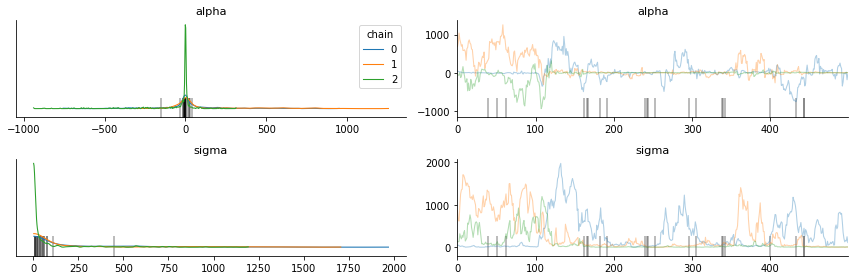

In [15]:
axs = az.plot_trace(trace_bad, compact=False, legend=True, divergences=True)
sns.despine()
plt.tight_layout()

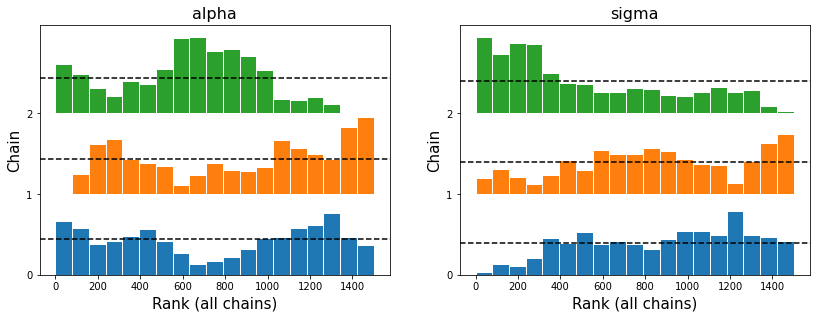

In [16]:
az.plot_rank(trace_bad);

## Sensible prior

In [17]:
prior_alpha_good = tfp.distributions.Normal(1, 10)
prior_sigma_good = tfp.distributions.Exponential(1)

In [18]:
def log_joint_prob_good_prior(params, obs_data=y):
    alpha, sigma = params["alpha"], params["sigma"]
    # prior
    log_prob_alpha = prior_alpha_good.log_prob(alpha)
    log_prob_sigma = prior_sigma_good.log_prob(sigma)
    log_prior = log_prob_alpha + log_prob_sigma

    # likelihood
    log_likelihood = tfp.distributions.Normal(loc=alpha, scale=sigma).log_prob(obs_data).sum()

    return log_prior + log_likelihood

In [19]:
rng_key = jax.random.PRNGKey(6)
initial_positions_good = {
    "alpha": prior_alpha_good.sample(n_chains, seed=rng_key),
    "sigma": prior_sigma_good.sample(n_chains, seed=rng_key),
}
initial_positions_good

{'alpha': DeviceArray([-10.364823 ,   3.4156868,  -8.575124 ], dtype=float32),
 'sigma': DeviceArray([2.0566835, 0.51845  , 1.776944 ], dtype=float32)}

In [20]:
inv_mass_matrix = jnp.array([0.1, 0.1])
step_size = 0.05
model = blackjax.nuts(log_joint_prob_good_prior, step_size, inv_mass_matrix)

In [21]:
initial_states = jax.vmap(model.init)(initial_positions_good)
initial_states

HMCState(position={'alpha': DeviceArray([-10.364823 ,   3.4156868,  -8.575124 ], dtype=float32), 'sigma': DeviceArray([2.0566835, 0.51845  , 1.776944 ], dtype=float32)}, potential_energy=DeviceArray([34.837852, 51.418835, 32.049313], dtype=float32), potential_energy_grad={'alpha': DeviceArray([-5.014335 , 25.439398 , -5.5272903], dtype=float32), 'sigma': DeviceArray([ -22.954865, -176.93663 ,  -24.442291], dtype=float32)})

In [22]:
# sanity check
jax.vmap(log_joint_prob_good_prior)(initial_positions_good)

DeviceArray([-34.837852, -51.418835, -32.049313], dtype=float32)

In [23]:
%%time
kernel = jax.jit(model.step)
states_and_info = inference_loop_multiple_chains(jax.random.PRNGKey(1), kernel, initial_states, n_samples, n_chains)
states, info = states_and_info["states"], states_and_info["info"]

CPU times: user 3.69 s, sys: 36.8 ms, total: 3.72 s
Wall time: 3.68 s


In [24]:
print(f"Number of divergences (good prior) = {info.is_divergent[burn_in:,:].sum()}")

Number of divergences (good prior) = 0


In [25]:
trace_good, samples_good = create_trace_from_states(states, info, burn_in=burn_in)
az.summary(trace_good)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.042,1.077,-2.032,2.056,0.051,0.043,472.0,389.0,1.00
sigma,1.489,0.744,0.428,2.803,0.043,0.031,354.0,414.0,1.01


In [26]:
print(
    f"alpha:{trace_good.posterior.alpha.shape}\nsigma:{trace_good.posterior.sigma.shape}\ndivergence:{trace_good.sample_stats.diverging.shape}"
)

alpha:(3, 500)
sigma:(3, 500)
divergence:(3, 500)


### Arviz plots

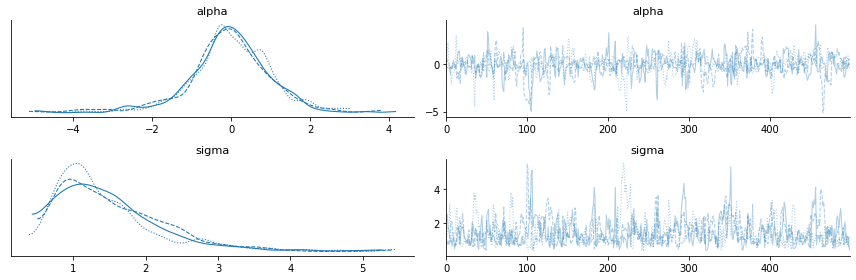

In [27]:
az.plot_trace(trace_good)
plt.tight_layout()
sns.despine()

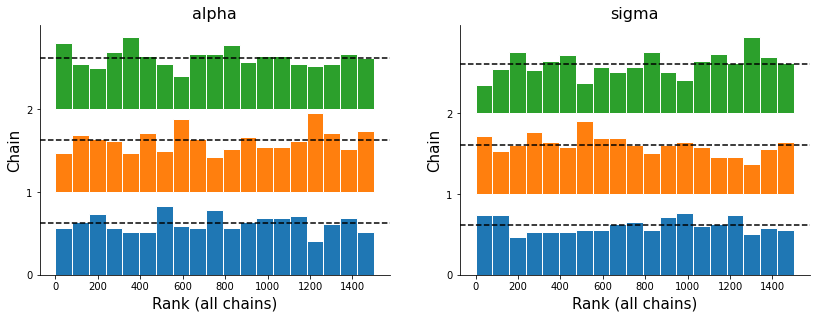

In [28]:
az.plot_rank(trace_good)
sns.despine();

## Latexified Figures

In [29]:
# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures"
# os.environ.pop("LATEXIFY")

In [30]:
def plot_trace(trace, fig_name=None):
    pml.latexify(width_scale_factor=1, fig_height=2)
    fig, axes = plt.subplots(2, 2)
    axs = az.plot_trace(
        trace,
        compact=False,
        divergences=True,
        axes=axes,
        plot_kwargs={"lw": 0.8},
        trace_kwargs={"lw": 0.8, "alpha": 0.8},
    )
    axes = axes.flatten()

    # set divergence vertical lines height and width
    scale = 0.001
    for ax in axes:
        ax.set_yticks(jnp.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 3))
        lines = ax.get_lines()
        if len(lines) == 3:
            continue
        for line in lines[3:]:
            line.set_markeredgewidth(1)
            line.set_markersize(10)
            line.set_alpha(0.8)

    # set legend
    leg_ax = axes[2]
    l = leg_ax.get_lines()
    leg_ax.legend(handles=l, labels=["chain1", "chain2", "chain3"], fontsize=8, framealpha=0.5)

    # set title
    axes[0].set_title("alpha")
    axes[1].set_title("alpha")
    axes[2].set_title("sigma")
    axes[3].set_title("sigma")

    sns.despine()
    plt.tight_layout()
    if fig_name:
        pml.savefig(fig_name)

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")
/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


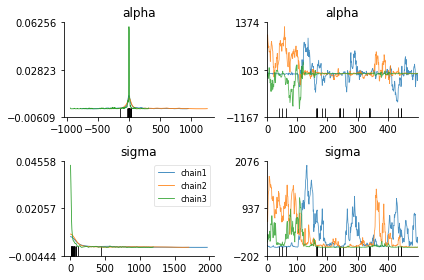

In [31]:
plot_trace(trace_bad, "mcmc_traceplot_unigauss_bad")

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")
/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


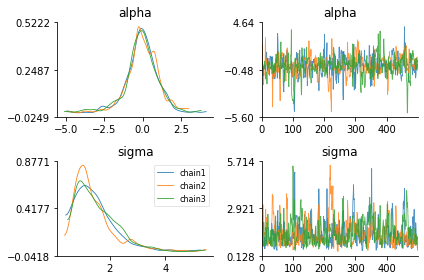

In [32]:
plot_trace(trace_good, "mcmc_traceplot_unigauss_good")

In [33]:
def plot_rank(trace, fig_name=None):
    pml.latexify(width_scale_factor=1, fig_height=2)
    fig, axes = plt.subplots(1, 2)
    az.plot_rank(trace, ax=axes)
    sns.despine()
    if fig_name:
        pml.savefig(fig_name)

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


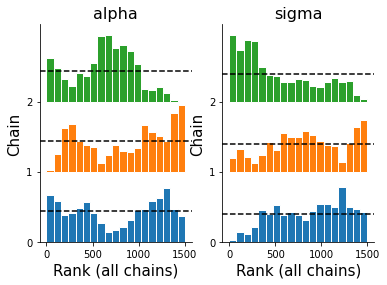

In [34]:
plot_rank(trace_bad, "mcmc_trankplot_unigauss_bad")

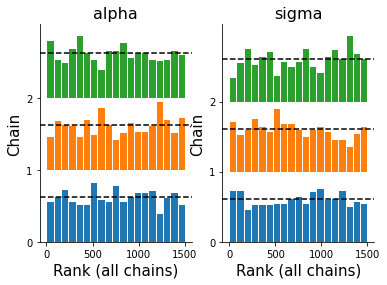

In [35]:
plot_rank(trace_good, "mcmc_trankplot_unigauss_good")